In [1]:
import math
import pydicom
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

### Load Image

In [2]:
DICOM_PATH = "images/DICOMOBJ/test-L"
IS_ROTATE = False 
# arrays = []

dicom_data = pydicom.dcmread(DICOM_PATH)
arr = dicom_data.pixel_array
if IS_ROTATE:
    arr = ndimage.rotate(arr, 90)

### Helper Functions

In [3]:
def inv_lut(arr: np.array):
    max_pixel = arr.max()
    min_pixel = arr.min()
    return max_pixel - arr + min_pixel

def display(arr: np.array, axis=False) :
    plt.imshow(arr, cmap="gray")
    plt.axis(axis)

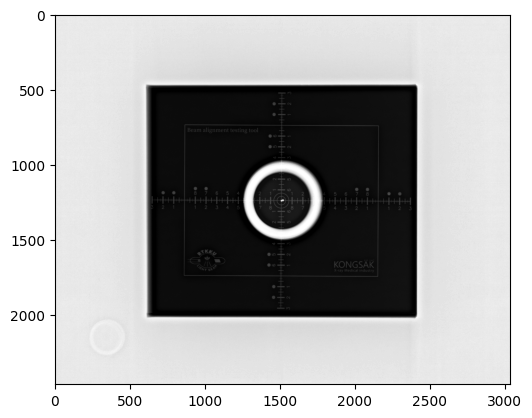

In [4]:
display(arr, True)

In [5]:
arr

array([[    0,     0,     0, ...,     0,     0,     0],
       [    0,     0,     0, ...,     0,     0,     0],
       [    0,     0, 14533, ..., 15404, 15069, 15296],
       ...,
       [    0,     0, 14861, ..., 14673, 15242, 14776],
       [    0,     0, 14668, ..., 15260, 14710, 15288],
       [    0,     0, 15517, ..., 14839, 14860, 14864]], dtype=uint16)

### Find Test-Tool

In [6]:
# assume crop if each size > 2,000 (not crop yet)
H, W = arr.shape
P = 0.24 # experimental number (Percent)
if (H*W) > (2000**2):
    arr = arr[int(H*P): int(H*(1-P)), int(W*P): int(W*(1-P))]
    H, W = arr.shape

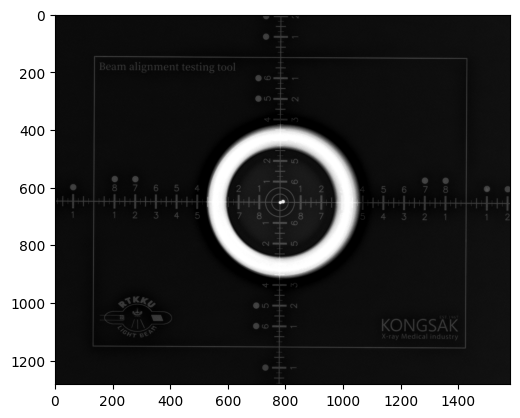

In [7]:
display(arr, True)

### Find Lines and Center of the Image

In [8]:
def most_common(focus_arr: np.array, axis=0) :
    """
    find most common pixel value in specific axis
    axis 0 = by col, axis 1 = by row
    return: most common pixel value
    """
    pixel_vals = np.argmax(focus_arr, axis=axis) # [b, w] color (if inv use argmin)
    unique_vals, counts = np.unique(pixel_vals, return_counts=True)
    most_common_idx = np.argmax(counts)
    pixel_val = unique_vals[most_common_idx]
    return pixel_val

- Find Center Line(Horizontal)

In [9]:
hp = int(0.2*H)
wp = int(0.06*W)

focus_l = arr[hp: H-hp, wp: wp*2]
focus_r = arr[hp: H-hp, W-(wp*2): W-wp]

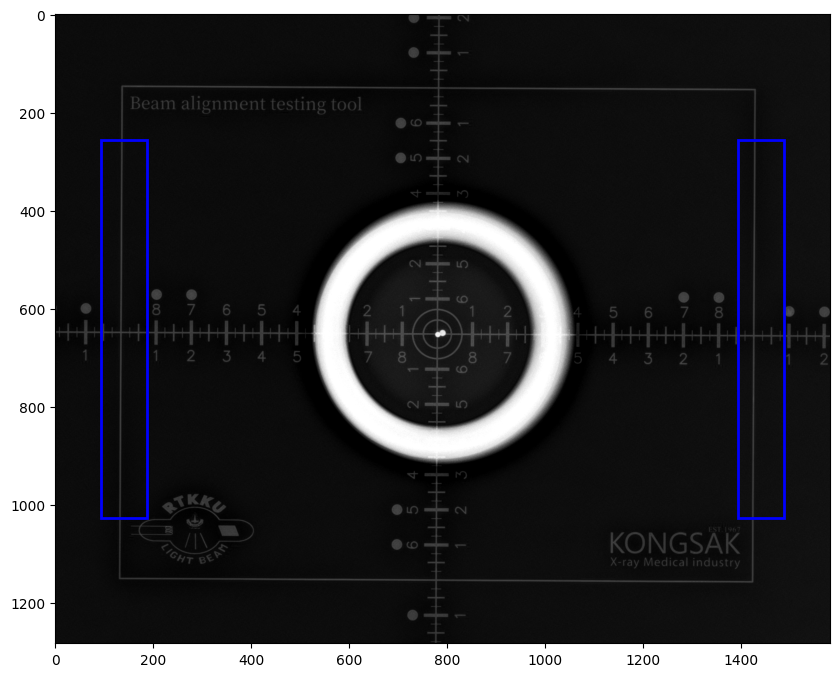

In [10]:
import matplotlib.patches as patches

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(arr, cmap='gray')

# Top-Left(x, y), width, heigh
l_rec = patches.Rectangle((wp, hp), wp, H-2*hp, linewidth=2, edgecolor='blue', facecolor='none')
r_rec = patches.Rectangle((W-(wp*2), hp), (W-wp)-(W-(wp*2)), (H-hp)-hp, linewidth=2, edgecolor='blue', facecolor='none')
ax.add_patch(l_rec)
ax.add_patch(r_rec)

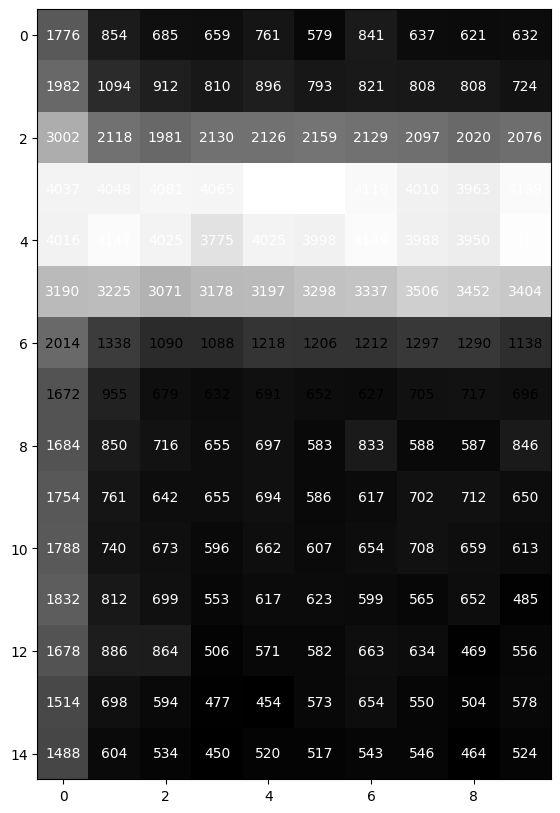

In [11]:
focus_v = arr[645: 660, 100: 110]

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(focus_v, cmap='gray')

# Annotate each pixel with its value
for i in range(focus_v.shape[0]): 
    for j in range(focus_v.shape[1]):  
        text = f"{focus_v[i, j]}"
        if i == 6 or i == 7 :
            c = "black"
        else: 
            c = "white"
        ax.text(j, i, text, ha="center", va="center", color=c, fontsize=10)

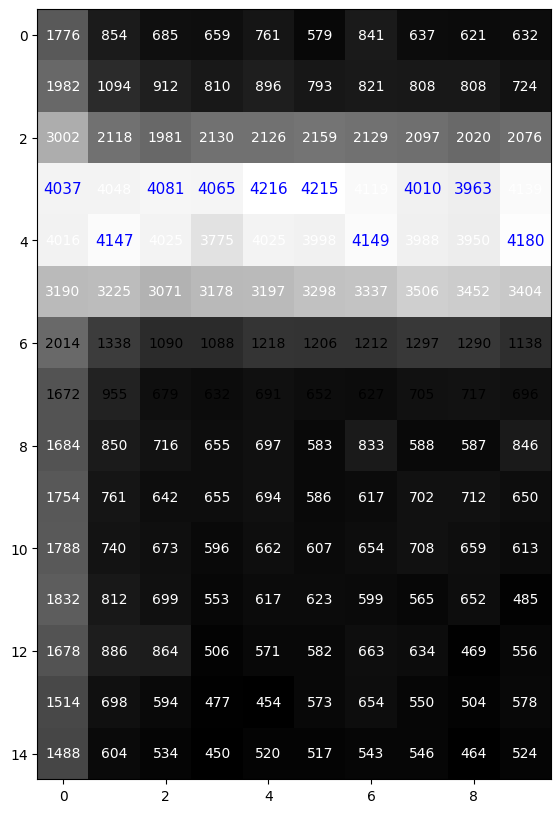

In [12]:
fig, ax = plt.subplots(figsize=(10, 10))
im = ax.imshow(focus_v, cmap='gray')

max_c = np.argmax(focus_v, axis=0)
for i in range(focus_v.shape[0]): 
    for j in range(focus_v.shape[1]):  
        text = f"{focus_v[i, j]}"
        if i == 6 or i == 7 :
            c = "black"
        else: 
            c = "white"
        if i == max_c[j] :
            c = "blue"
            size = 11
        else :
            size = 10
        ax.text(j, i, text, ha="center", va="center", color=c, fontsize=size)

In [13]:
y1 = most_common(focus_l, axis=0) + hp # start at hp not 0
y2 = most_common(focus_r, axis=0) + hp 
y1, y2

(649, 656)

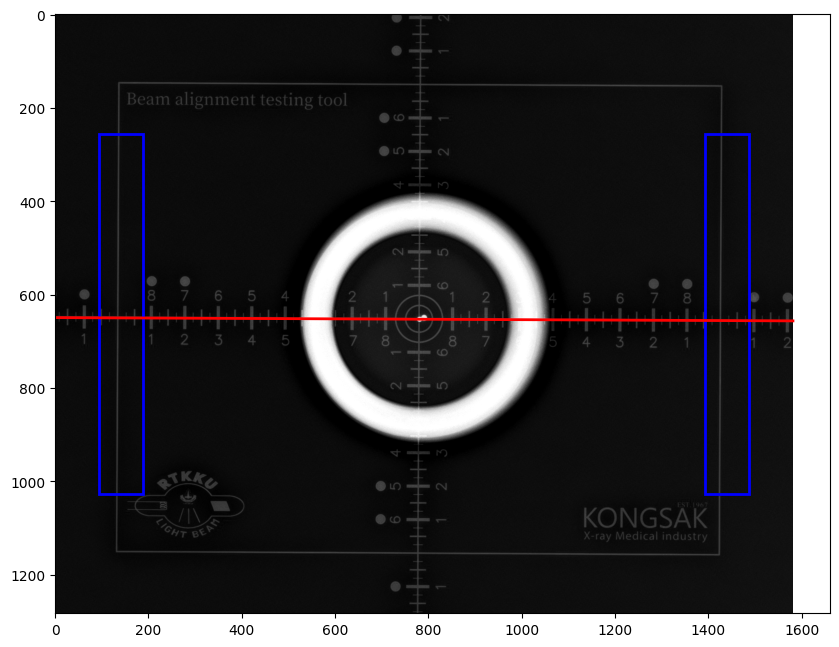

In [14]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(arr, cmap='gray')

# Top-Left(x, y), width, heigh
l_rec = patches.Rectangle((wp, hp), wp, H-2*hp, linewidth=2, edgecolor='blue', facecolor='none')
r_rec = patches.Rectangle((W-(wp*2), hp), (W-wp)-(W-(wp*2)), (H-hp)-hp, linewidth=2, edgecolor='blue', facecolor='none')
plt.plot([0, W], [y1, y2], linewidth=2, color="red")
ax.add_patch(l_rec)
ax.add_patch(r_rec)

In [15]:
def find_theta(x1, x2, y1, y2):
    """
    find theta from given width(x1, x2) and height(y1, y2)
    return: theta in degree
    """
    a = y2 - y1
    w = x2 - x1
    theta_r = math.atan(a/w)
    theta_d = math.degrees(theta_r)
    return theta_d

In [16]:
def find_center_line(arr: np.array):
    """
    find horizontal center line
    theta: alignment of the center line
    return (x1, y1), (x2, y2), (theta)
    """
    H, W = arr.shape
    hp = int(0.2*H)
    wp = int(0.06*W)

    # left point
    focus_l = arr[hp: H-hp, wp: wp*2]
    y1 = most_common(focus_l, axis=0) + hp
    
    # right point
    focus_r = arr[hp: H-hp, W-(wp*2): W-wp]
    y2 = most_common(focus_r, axis=0) + hp

    theta = find_theta(wp, W-(wp*2), y1, y2)
    
    return (0, y1), (W-1, y2), theta # W-1 for visualize not over blank

In [17]:
def draw_line(arr, x1, y1, x2, y2, axis=False, color="blue") :
    plt.imshow(arr, cmap="gray")
    plt.plot([x1, x2], [y1, y2], color=color, linewidth=1)
    plt.axis(axis)

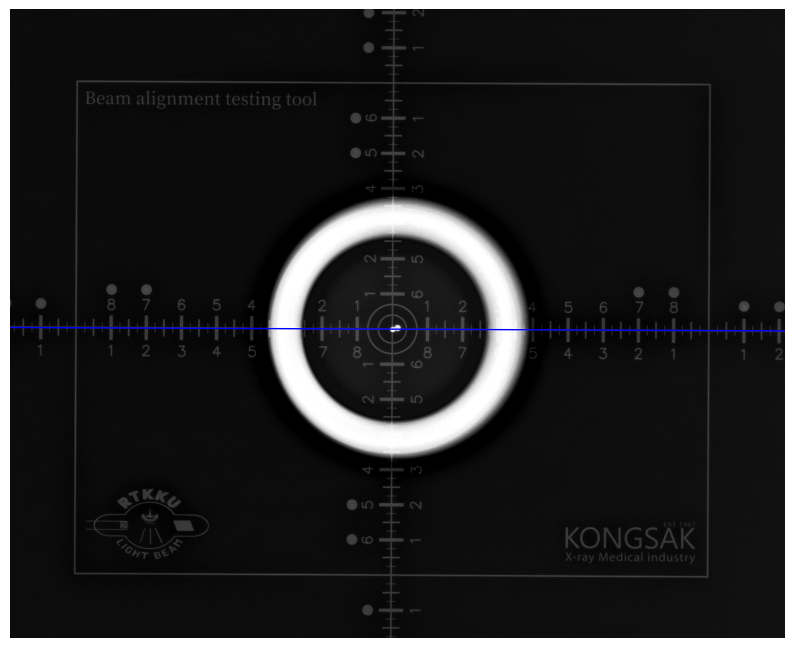

In [18]:
(x1, y1), (x2, y2), (theta_d) = find_center_line(arr)
plt.figure(figsize=(10, 10))
draw_line(arr, x1, y1, x2, y2)

In [19]:
theta_d

0.3087502497810308

### Rotate image by theta_d

In [20]:
# CCW rotate
rotate_img = ndimage.rotate(arr, theta_d, reshape=False, cval=arr.max())
h, w = rotate_img.shape

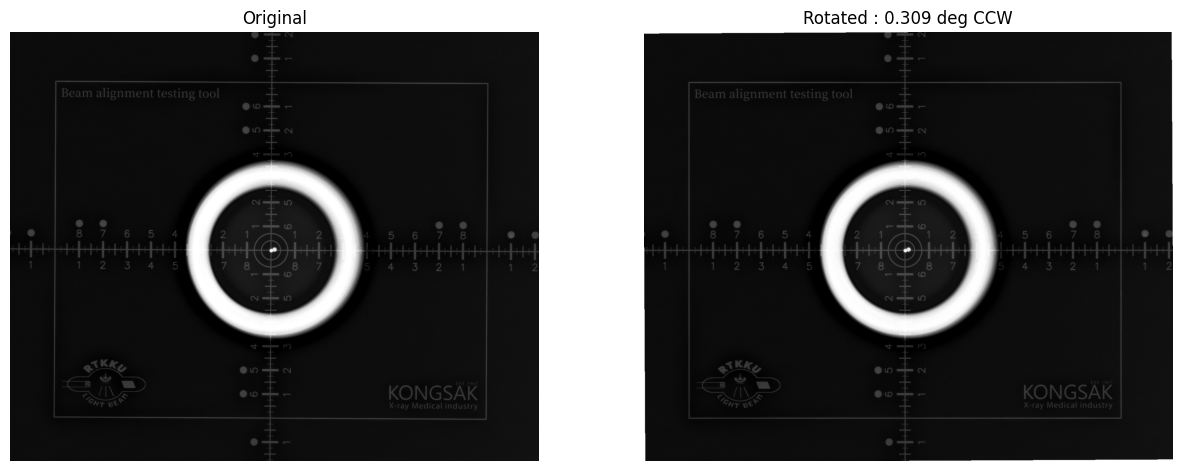

In [21]:
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.title("Original")
display(arr)

plt.subplot(1, 2, 2)
plt.title(f"Rotated : {theta_d:.3f} deg CCW")
display(rotate_img)

### Find Lines in Rotated Image

In [22]:
def find_horizontal_lines(arr: np.array):
    """
    find horizontal lines[y-axis]
    return: top, center, bottom [y1, y2]
    """
    ypoints = []
    h, w = arr.shape
    hp = int(0.27*h)
    wp = int(0.07*w)
    offset = 20 # padding from rotating error (for top and bottom)

    # top line
    focus_l = arr[offset: hp, wp*2: wp*3]
    y1 = most_common(focus_l, axis=0) + offset
    focus_r = arr[offset: hp, w-(wp*3): w-(wp*2)]
    y2 = most_common(focus_l, axis=0) + offset
    ypoints.append((y1, y2))

    # center line
    (_, y1), (_, y2), _ = find_center_line(arr)
    ypoints.append((y1, y2))

    # bottom line
    focus_l = arr[h-hp: h-offset, wp*4: wp*5]
    y1 = most_common(focus_l, axis=0) + h-hp
    focus_r = arr[h-hp: h-offset, w-(wp*3): w-(wp*2)]
    y2 = most_common(focus_r, axis=0) + h-hp
    ypoints.append((y1, y2))

    return ypoints

In [23]:
ypoints = find_horizontal_lines(rotate_img)
ypoints

[(150, 150), (652, 652), (1154, 1154)]

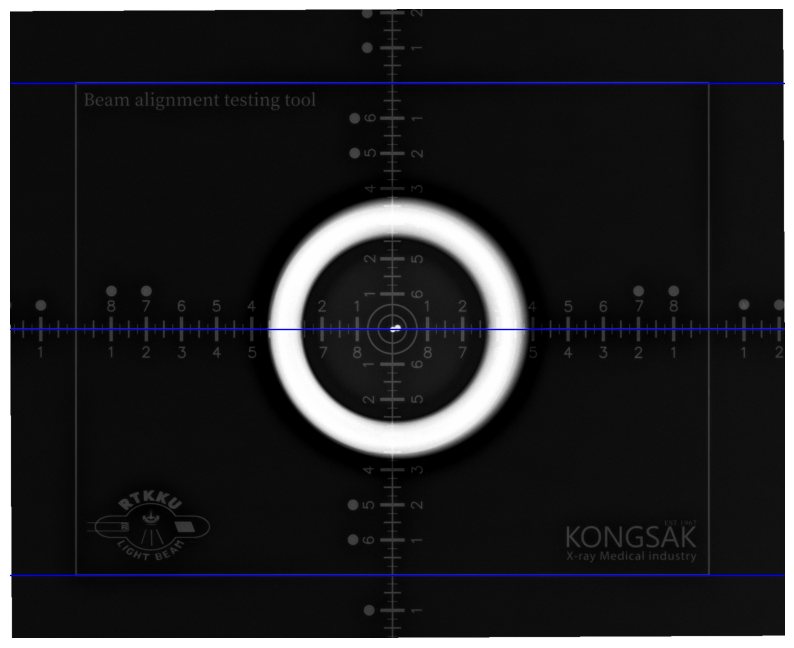

In [24]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, 0, ypoints[idx][0], w-1, ypoints[idx][1])

In [25]:
def find_vertical_line(arr: np.array):
    """
    find vertical lines[x-axis]
    Return: (top(x1, x2), center(x1, x2), bottom(x1, x2))
    """
    xpoints = []
    h, w = arr.shape
    hp = int(0.05*h) # crop ratio
    wp = int(0.04*w)

    # left line
    focus_t = arr[hp*3: hp*7, wp: wp*6]
    x1 = most_common(focus_t, axis=1) + wp
    focus_b = arr[h-hp*7: h-hp*3, wp: wp*6]
    x2 = most_common(focus_b, axis=1) + wp
    xpoints.append((x1, x2))

    # right line
    focus_t = arr[hp*3: hp*7, w-(wp*6): w-wp]
    x1 = most_common(focus_t, axis=1) + w-(wp*6)
    focus_b = arr[h-hp*7: h-hp*3, w-(wp*6): w-wp]
    x2 = most_common(focus_b, axis=1) + w-(wp*6)
    xpoints.append((x1, x2))

    # center line
    hp = int(0.18*h)
    wp = int(0.2*w)

    focus_t = arr[hp: hp*2, wp*2: wp*3]
    x1 = most_common(focus_t, axis=1) + (wp*2)
    focus_b = arr[h-(hp*2): h-hp, wp*2: wp*3]
    x2 = most_common(focus_b, axis=1) + (wp*2)
    xpoints.append((x1, x2))

    # swap bottom and center in xpoints
    centerpoints = xpoints[-1]
    xpoints[-1] = xpoints[1]
    xpoints[1] = centerpoints
    return xpoints

In [26]:
xpoints = find_vertical_line(rotate_img)
xpoints

[(134, 134), (780, 780), (1425, 1425)]

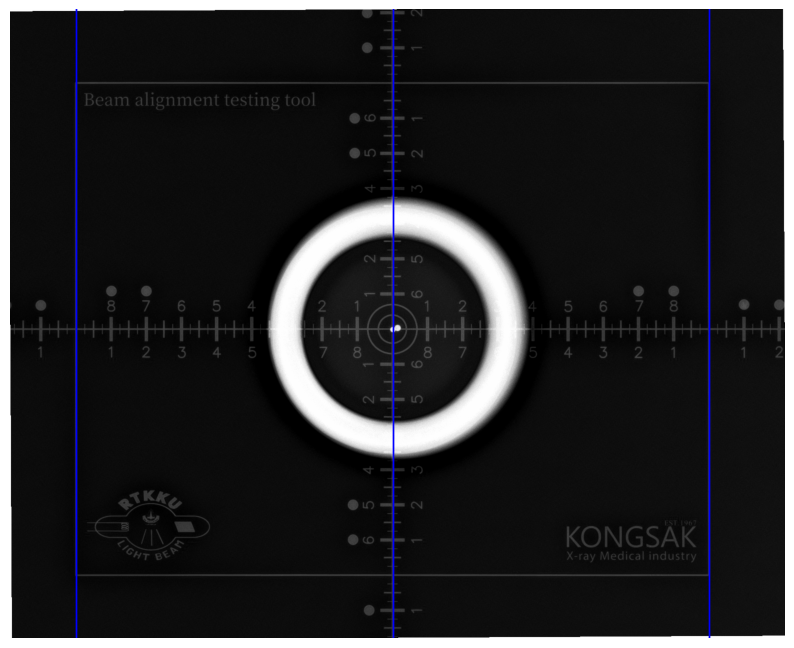

In [27]:
plt.figure(figsize=(10, 10))
for idx in range(len(xpoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h-1)

### Can optimize this
- TODO: select one value (y2, y1) -> y

In [28]:
xpoints = [round(np.mean(xpoints[idx])) for idx in range(3)]
ypoints = [round(np.mean(ypoints[idx])) for idx in range(3)]
xpoints, ypoints

([134, 780, 1425], [150, 652, 1154])

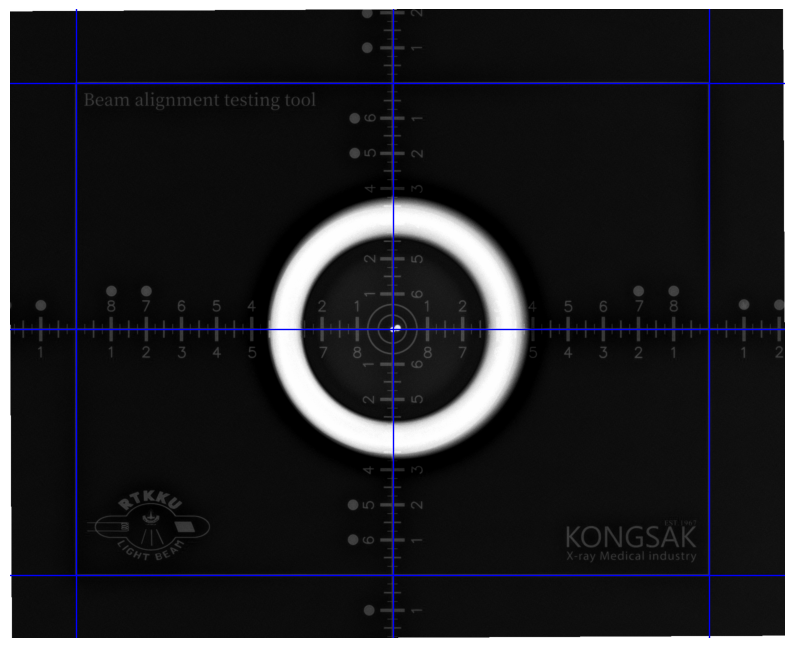

In [29]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], 0, xpoints[idx], h-1)
    draw_line(rotate_img, 0, ypoints[idx], w-1, ypoints[idx])

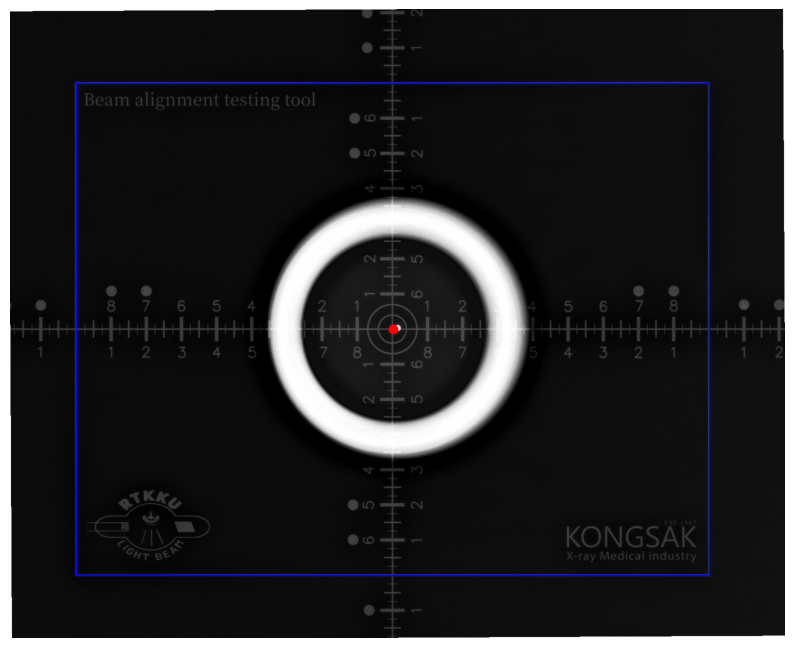

In [30]:
plt.figure(figsize=(10, 10))
for idx in range(len(ypoints)) : 
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[idx], ypoints[-idx-1])
    draw_line(rotate_img, xpoints[idx], ypoints[idx], xpoints[-idx-1], ypoints[idx])
plt.plot((xpoints[1]), (ypoints[1]), 'o', color="red")

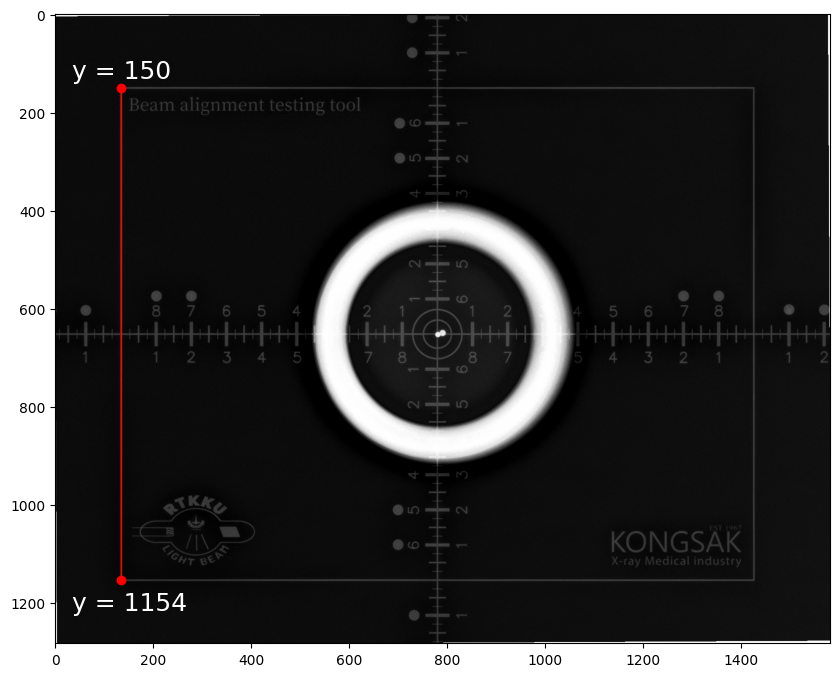

In [31]:
plt.figure(figsize=(10, 10))

draw_line(rotate_img, xpoints[0], ypoints[0], xpoints[0], ypoints[2], color="red")
plt.axis(True)
plt.text(xpoints[0]-100, ypoints[0]-20, f"y = {ypoints[0]}", fontsize = 18, color="white")
plt.plot((xpoints[0]), (ypoints[0]), 'o', color="red")
plt.text(xpoints[0]-100, ypoints[2]+60, f"y = {ypoints[2]}", fontsize = 18, color="white")
plt.plot((xpoints[0]), (ypoints[2]), 'o', color="red")

In [32]:
print(f"18cm [horizontal] equal: {xpoints[2]} - {xpoints[0]} = {xpoints[2] - xpoints[0]} pixels")
print(f"14cm [vertical] equal: {ypoints[2]} - {ypoints[0]} = {ypoints[2] - ypoints[0]} pixels")

18cm [horizontal] equal: 1425 - 134 = 1291 pixels
14cm [vertical] equal: 1154 - 150 = 1004 pixels


In [33]:
def pixel2cm(ypoints, number_pixels: int, is_rotate = False):
    """
    convert number of pixels to centimeter as aspect ratio
    """
    pixels_y = ypoints[2] - ypoints[0]
    cm_y = 14
    if is_rotate: cm_y = 18
    return round(number_pixels*cm_y/pixels_y, 2)

In [34]:
pixel2cm(ypoints, 1004)

14.0

In [35]:
def cm2pixel(ypoints, cm: float, is_rotate = False):
    """
    convert centimeter to number of pixels as aspect ratio
    """
    pixels_y = ypoints[2] - ypoints[0]
    cm_y = 14
    if is_rotate: cm_y = 18
    return round(pixels_y*cm/cm_y)

In [36]:
cm2pixel(ypoints, 14)

1004

## Field 14x18 cm

### Find the circles

In [37]:
one_cm_pixel = cm2pixel(ypoints, 1)
one_cm_pixel

72

In [38]:
xx = xpoints[1]-one_cm_pixel, xpoints[1]+one_cm_pixel
yy = ypoints[1]-one_cm_pixel, ypoints[1]+one_cm_pixel
xx, yy

((708, 852), (580, 724))

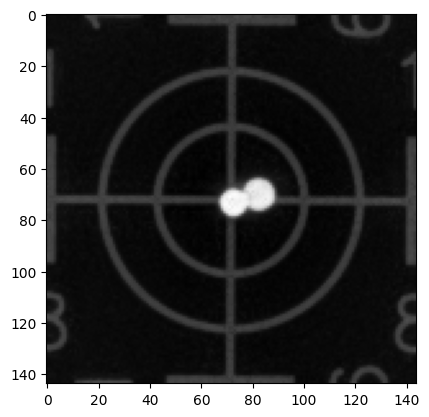

In [39]:
circle_focus = arr[yy[0]: yy[1], xx[0]: xx[1]]
display(circle_focus, True)

In [40]:
inner_cir_r = cm2pixel(ypoints, 0.41)
outter_cir_r = cm2pixel(ypoints, 0.71)
inner_cir_r, outter_cir_r

(29, 51)

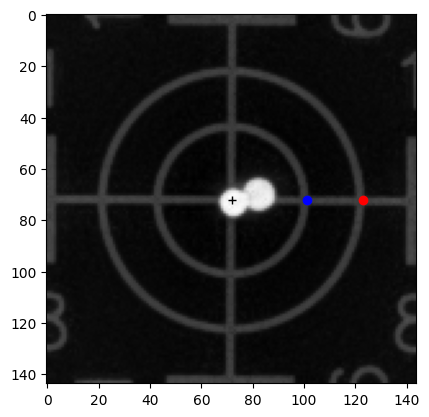

In [41]:
h = k = circle_focus.shape[0]//2
display(circle_focus, True)
plt.plot(h, k, "+", color="black")
plt.plot(h+inner_cir_r, k, "o", color="blue")
plt.plot(h+outter_cir_r, k, "o", color="red")

In [42]:
# (x-h)**2 + (y-k)**2 <= r**2
inner_points = []
outter_points = []
h = k = circle_focus.shape[0]//2
cols = rows = circle_focus.shape[0]
for col in range(cols):
    for row in range(rows):
        x, y = col, row
        if (x-h)**2 + (y-k)**2 == inner_cir_r**2 :
            inner_points.append([x, y])
        elif (x-h)**2 + (y-k)**2 == outter_cir_r**2:
            outter_points.append([x, y])

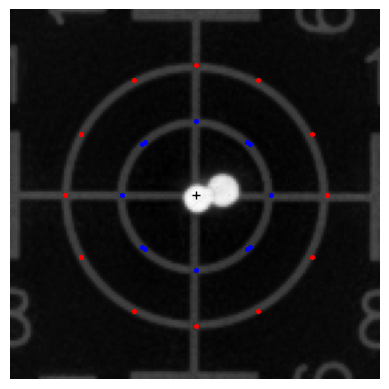

In [43]:
inner_points = np.array(inner_points)
outter_points = np.array(outter_points)

plt.plot(h, k, "+", color="black")
plt.scatter(outter_points[:, 0], outter_points[:, 1], s=7, c='red')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s=7, c='blue')
display(circle_focus)

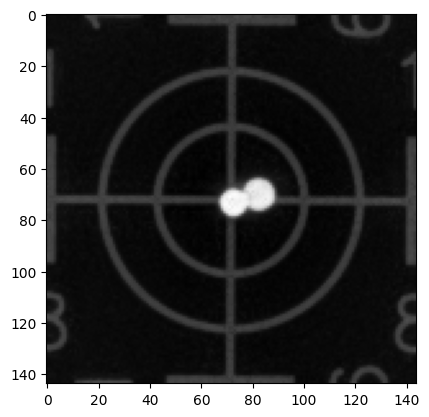

In [44]:
display(circle_focus, True)

In [45]:
# find edge of point
# split to 4 area -> find the fartest white in row, col then 
not_point_pixel_ts = 5
white_ts = int(np.percentile(circle_focus, q=99))

In [46]:
def find_center_circle_lines(arr: np.array):
    H, W = arr.shape
    hp = int(0.2*H)
    wp = int(0.06*W)

    # left point
    focus_l = arr[hp: H-hp, wp: wp*2]
    y1 = most_common(focus_l, axis=0) + hp
    # right point
    focus_r = arr[hp: H-hp, W-(wp*2): W-wp]
    y2 = most_common(focus_r, axis=0) + hp
    # avg y 
    y = math.ceil((y1 + y2)/2)

    # top point
    focus_l = arr[wp: wp*2, hp: H-hp]
    x1 = most_common(focus_l, axis=1) + hp
    # bottom point
    focus_r = arr[W-(wp*2): W-wp, hp: H-hp]
    x2 = most_common(focus_r, axis=1) + hp
    # avg x
    x = math.ceil((x1 + x2)/2)

    return x, y

In [47]:
xc, yc = find_center_circle_lines(circle_focus)
xc, yc

(72, 73)

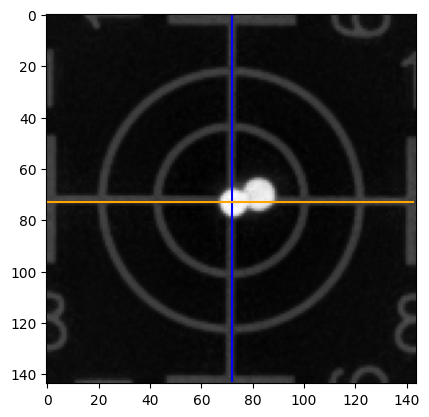

In [48]:
display(circle_focus, True)
plt.vlines([xc], ymin=0, ymax=rows-1, color="blue")
plt.hlines([yc], xmin=0, xmax=cols-1, color="orange")

In [49]:
top_left = circle_focus[:yc, :xc]
top_right = circle_focus[:yc , xc+1:] # doesn't count center
bottom_left = circle_focus[yc+1:, :xc]
bottom_right = circle_focus[yc+1:, xc+1:]

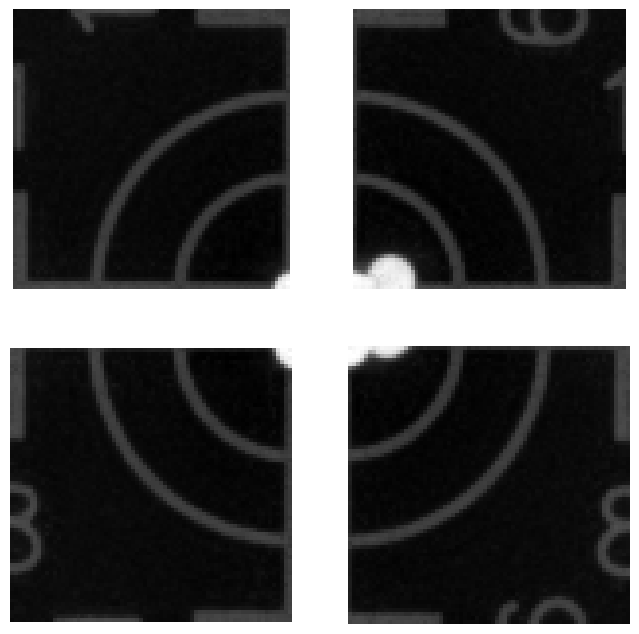

In [50]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 2, 1)
display(top_left)
plt.subplot(2, 2, 2)
display(top_right)
plt.subplot(2, 2, 3)
display(bottom_left)
plt.subplot(2, 2, 4)
display(bottom_right)

## Experimental

In [51]:
# top left: start nrows, ncols [optimize]
nrows, ncols = top_left.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = nrows-row-1 # last row
        new_col = ncols-col-1 # last col
        p_val = top_left[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
pause
0

row: 1
0
1
2
3
4
5
6
7
8
pause
0

row: 2
0
1
2
3
4
5
6
7
pause
0

row: 3
0
1
2
3
4
5
6
pause
0

row: 4
0
1
2
3
4
pause
1

row: 5
0
1
2
3
4
pause
2

row: 6
0
1
2
3
4
pause
3

row: 7
0
1
2
3
4
pause
4

row: 8
0
1
2
3
4
pause
5


In [52]:
fartest_col

[0, 3]

In [53]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = nrows-row-1 # last row
        new_col = ncols-col-1 # last col
        p_val = top_left[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
pause
0

col: 1
0
1
2
3
4
5
6
7
8
pause
0

col: 2
0
1
2
3
4
5
6
7
pause
0

col: 3
0
1
2
3
4
5
6
pause
0

col: 4
0
1
2
3
4
pause
1

col: 5
0
1
2
3
4
pause
2

col: 6
0
1
2
3
4
pause
3

col: 7
0
1
2
3
4
pause
4

col: 8
0
1
2
3
4
pause
5


In [54]:
fartest_row, fartest_col

([3, 0], [0, 3])

In [55]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(top_left[nrows-row_idx-1, ncols-col_idx-1:][::-1])
fartest_row

[3, 0]

In [56]:
# find most white row for col
fartest_col[0] = np.argmax(top_left[nrows-row_idx-1:, ncols-col_idx-1][::-1])
fartest_col

[0, 3]

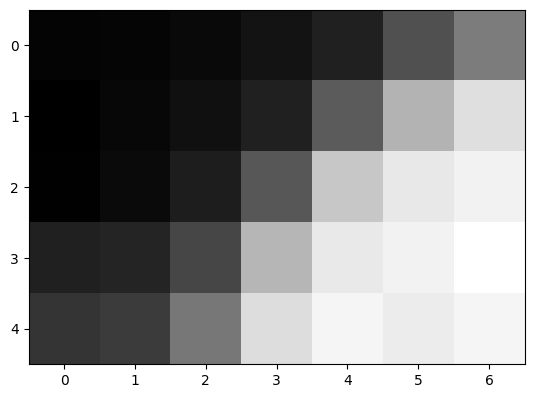

In [57]:
display(top_left[68:, 65: ], True)

In [58]:
top_left[68:, 65: ]

array([[ 2012,  2040,  2265,  2861,  3567,  6314,  8817],
       [ 1731,  2160,  2652,  3601,  6958, 12036, 14503],
       [ 1817,  2329,  3421,  6724, 13118, 14978, 15548],
       [ 3574,  3888,  5731, 12120, 15036, 15562, 16336],
       [ 4811,  5104,  8571, 14342, 15715, 15214, 15765]], dtype=uint16)

In [59]:
fartest_col, fartest_row

([0, 3], [3, 0])

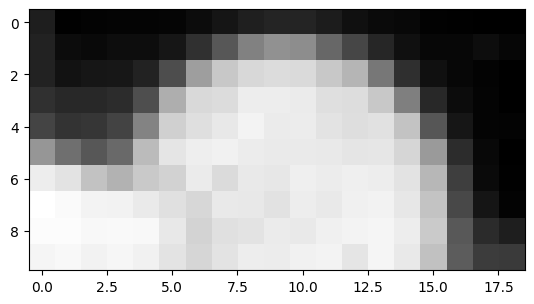

In [60]:
display(top_right[63:, :19], True)

In [61]:
white_ts

9529

In [62]:
np.set_printoptions(linewidth=500)
for i, v in enumerate(top_right[63:, :19]):
    print(9-i, v)

9 [3537 1945 2036 2096 2130 2174 2561 3041 3606 3969 3907 3432 2777 2459 2310 2020 1929 1862 1891]
8 [3783 2538 2397 2588 2608 3099 4637 6726 9063 9956 9725 7595 5761 3992 2761 2273 2283 2595 2227]
7 [ 3800  2909  3116  3167  3787  6171 10686 13002 13883 14120 13979 13001 11971  8512  4523  2805  2275  2082  1887]
6 [ 4567  4085  4135  4357  6245 11559 13933 14119 15083 15063 14930 14286 14189 13025  8937  4161  2535  2104  1899]
5 [ 5645  4713  4879  5615  9151 13431 14261 14754 15365 14944 15001 14510 14209 14373 12806  6647  3140  2087  2057]
4 [10200  8052  6707  7733 12265 14638 15121 15274 15017 14899 14911 14854 14636 14661 13797 10435  4372  2315  1862]
3 [15037 14506 12657 11759 13035 13561 14960 14076 14859 14712 15157 14997 15145 15077 14575 12034  5348  2433  1944]
2 [16087 15801 15386 15341 14891 14327 13862 14815 14761 14466 15032 14839 15226 15344 14744 12700  5864  3084  2074]
1 [15901 15887 15665 15712 15643 14767 13680 14364 14512 14930 14864 15208 15368 15499 15056 1

In [63]:
# top right: start nrows, 0 [optimize]
nrows, ncols = top_right.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = nrows-row-1 # last row
        new_col = col # first col
        p_val = top_right[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 3
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 4
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
pause
0

row: 5
0
1
2
3
4
pause
1

row: 6
0
1
2
3
4
pause
2

row: 7
0
1
2
3
4
pause
3

row: 8
0
1
2
3
4
pause
4

row: 9
0
1
2
3
4
pause
5


In [64]:
fartest_col

[0, 15]

In [65]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = nrows-row-1 # last row
        new_col = col # first col
        p_val = top_right[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
9
pause
0

col: 1
0
1
2
3
4
5
6
7
8
pause
0

col: 2
0
1
2
3
4
5
6
7
8
pause
0

col: 3
0
1
2
3
4
5
6
7
8
pause
0

col: 4
0
1
2
3
4
5
6
7
8
9
pause
0

col: 5
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 6
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 7
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 8
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 9
0
1
2
3
4
5
6
7
8
9
10
11
12
13
pause
0

col: 10
0
1
2
3
4
5
6
7
8
9
10
11
12
13
pause
0

col: 11
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 12
0
1
2
3
4
5
6
7
8
9
10
11
12
pause
0

col: 13
0
1
2
3
4
5
6
7
8
9
10
11
pause
0

col: 14
0
1
2
3
4
5
6
7
8
9
10
pause
0

col: 15
0
1
2
3
4
5
6
7
8
9
pause
0

col: 16
0
1
2
3
4
pause
1

col: 17
0
1
2
3
4
pause
2

col: 18
0
1
2
3
4
pause
3

col: 19
0
1
2
3
4
pause
4

col: 20
0
1
2
3
4
pause
5


In [66]:
fartest_col, fartest_row

([0, 15], [8, 0])

In [67]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(top_right[nrows-row_idx-1, :col_idx+1])
fartest_row

[8, 9]

In [68]:
# find most white row for col
fartest_col[0] = np.argmax(top_right[nrows-row_idx-1:, col_idx][::-1])
fartest_col

[1, 15]

In [69]:
bottom_left.shape

(70, 72)

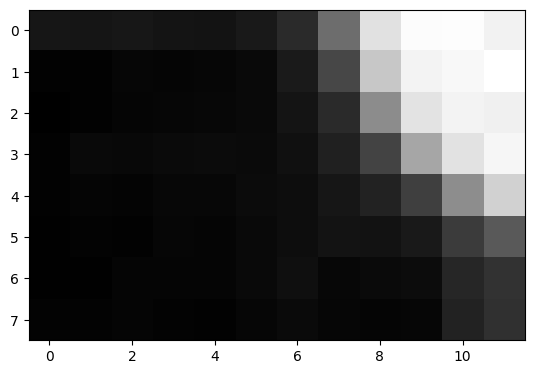

In [70]:
display(bottom_left[:8, 60:], True)

In [71]:
for i, v in enumerate(bottom_left[:8, 60:]):
    print(i, v)

0 [ 2349  2249  2398  2187  2167  2530  3536  7507 14366 16008 16046 15415]
1 [ 1150  1171  1406  1324  1412  1586  2544  5225 12816 15488 15722 16192]
2 [ 1000  1124  1336  1358  1442  1571  2203  3516  9362 14580 15491 15292]
3 [ 1173  1539  1496  1650  1668  1624  1997  2911  5018 10884 14452 15600]
4 [ 1150  1326  1288  1420  1470  1654  1828  2357  3044  4767  9370 13426]
5 [1060 1222 1161 1379 1342 1576 1786 2176 2126 2526 4542 6292]
6 [1074 1098 1330 1308 1301 1547 1912 1456 1620 1743 3280 4009]
7 [1181 1231 1302 1235 1151 1392 1634 1398 1324 1370 3028 3854]


In [72]:
# bottom left: start 0, ncols [optimize]
nrows, ncols = bottom_left.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = row # first row
        new_col = ncols-col-1 # last col
        p_val = bottom_left[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
pause
0

row: 1
0
1
2
3
4
5
6
7
8
pause
0

row: 2
0
1
2
3
4
5
6
7
pause
0

row: 3
0
1
2
3
4
5
6
7
pause
0

row: 4
0
1
2
3
4
5
pause
0

row: 5
0
1
2
3
4
pause
1

row: 6
0
1
2
3
4
pause
2

row: 7
0
1
2
3
4
pause
3

row: 8
0
1
2
3
4
pause
4

row: 9
0
1
2
3
4
pause
5


In [73]:
fartest_col

[0, 3]

In [74]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = row # first row
        new_col = ncols-col-1 # last col
        p_val = bottom_left[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
9
pause
0

col: 1
0
1
2
3
4
5
6
7
8
pause
0

col: 2
0
1
2
3
4
5
6
7
8
pause
0

col: 3
0
1
2
3
4
5
6
pause
0

col: 4
0
1
2
3
4
pause
1

col: 5
0
1
2
3
4
pause
2

col: 6
0
1
2
3
4
pause
3

col: 7
0
1
2
3
4
pause
4

col: 8
0
1
2
3
4
pause
5


In [75]:
fartest_row

[4, 0]

In [76]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(bottom_left[row_idx, ncols-col_idx-1:][::-1])
fartest_row

[4, 0]

In [77]:
# find most white row for col
fartest_col[0] = np.argmax(bottom_left[:row_idx+1, ncols-col_idx-1])
fartest_col

[0, 3]

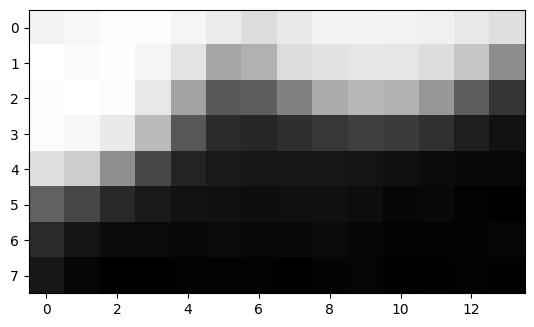

In [78]:
display(bottom_right[:8, :14], True)

In [79]:
for i, v in enumerate(bottom_right[:8, :14]):
    print(i, v)

0 [15352 15539 15828 15820 15436 14878 14064 14750 15367 15283 15242 15131 14659 14143]
1 [15959 15748 15905 15394 14464 10857 11495 13957 14297 14587 14544 14013 12677  9473]
2 [15946 16011 15816 14694 10703  6535  6785  8785 11200 11870 11557 10039  6739  4442]
3 [15819 15541 14750 12036  6394  3962  3583  4012  4571  5018  4751  4133  3091  2386]
4 [14189 13117  9560  5461  3401  2851  2652  2678  2645  2526  2268  2049  1840  1790]
5 [6997 5385 3759 2833 2400 2331 2203 2236 2321 2134 1749 1844 1516 1422]
6 [3801 2529 2051 1957 1858 1999 1879 1902 2036 1760 1498 1546 1653 1674]
7 [2726 1668 1375 1418 1506 1541 1502 1416 1658 1666 1388 1466 1554 1482]


In [80]:
# bottom left: start 0, 0 [optimize]
nrows, ncols = bottom_right.shape
fartest_col = [0, 0]
most_white_col = 0
not_white_r = 0
# find cols first
for row in range(nrows):
    print("row:", row)
    not_white_c = 0
    for col in range(ncols):
        new_row = row # first row
        new_col = col # first col
        p_val = bottom_right[new_row][new_col]
        print(col)
        if p_val >= white_ts:
            not_white_c = 0
            if col > fartest_col[1]:
                fartest_col[1] = col

        else:
            not_white_c += 1
            if not_white_c >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                print(not_white_r)
                break
    
    # break for row
    if not_white_r >= not_point_pixel_ts:
        break
    print()

row: 0
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
pause
0

row: 1
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
pause
0

row: 2
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
pause
0

row: 3
0
1
2
3
4
5
6
7
8
pause
0

row: 4
0
1
2
3
4
5
6
7
pause
0

row: 5
0
1
2
3
4
pause
1

row: 6
0
1
2
3
4
pause
2

row: 7
0
1
2
3
4
pause
3

row: 8
0
1
2
3
4
pause
4

row: 9
0
1
2
3
4
pause
5


In [81]:
fartest_col

[0, 14]

In [82]:
fartest_row = [0, 0]
most_white_row = 0
not_white_c = 0
# find cols first
for col in range(ncols):
    print("col:", col)
    not_white_r = 0
    for row in range(nrows):
        new_row = row # first row
        new_col = col # last col
        p_val = bottom_right[new_row][new_col]
        print(row)
        if p_val >= white_ts:
            not_white_r = 0
            if row > fartest_row[0]:
                fartest_row[0] = row

        else:
            not_white_r += 1
            if not_white_r >= not_point_pixel_ts:
                print("pause")
                # break for row
                not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                print(not_white_c)
                break
    
    # break for row
    if not_white_c >= not_point_pixel_ts:
        break
    print()

col: 0
0
1
2
3
4
5
6
7
8
9
pause
0

col: 1
0
1
2
3
4
5
6
7
8
9
pause
0

col: 2
0
1
2
3
4
5
6
7
8
9
pause
0

col: 3
0
1
2
3
4
5
6
7
8
pause
0

col: 4
0
1
2
3
4
5
6
7
pause
0

col: 5
0
1
2
3
4
5
6
pause
0

col: 6
0
1
2
3
4
5
6
pause
0

col: 7
0
1
2
3
4
5
6
pause
0

col: 8
0
1
2
3
4
5
6
7
pause
0

col: 9
0
1
2
3
4
5
6
7
pause
0

col: 10
0
1
2
3
4
5
6
7
pause
0

col: 11
0
1
2
3
4
5
6
7
pause
0

col: 12
0
1
2
3
4
5
6
pause
0

col: 13
0
1
2
3
4
5
pause
0

col: 14
0
1
2
3
4
5
pause
0

col: 15
0
1
2
3
4
pause
1

col: 16
0
1
2
3
4
pause
2

col: 17
0
1
2
3
4
pause
3

col: 18
0
1
2
3
4
pause
4

col: 19
0
1
2
3
4
pause
5


In [83]:
fartest_row

[4, 0]

In [84]:
# find most white col for row
row_idx, col_idx = fartest_row[0], fartest_col[1] # range
fartest_row[1] = np.argmax(bottom_right[row_idx, :col_idx+1])
fartest_row

[4, 0]

In [85]:
fartest_col[0] = np.argmax(bottom_right[:row_idx+1, col_idx])
fartest_col

[0, 14]

## Solution

In [86]:
def find_fartest_white(focus_arr: np.array, first_row: bool, first_col: bool):
    nrows, ncols = focus_arr.shape
    fartest_col = 0
    not_white_r = 0
    # find cols first
    for row in range(nrows):
        not_white_c = 0
        for col in range(ncols):
            new_row = row if first_row else nrows-row-1
            new_col = col if first_col else ncols-col-1 
            p_val = focus_arr[new_row][new_col]
            if p_val >= white_ts:
                not_white_c = 0
                if col > fartest_col:
                    fartest_col = col
            else:
                not_white_c += 1
                if not_white_c >= not_point_pixel_ts:
                    # break for row
                    not_white_r += 1 if col == not_point_pixel_ts-1 else 0
                    break
        # break for row
        if not_white_r >= not_point_pixel_ts:
            break

    fartest_row = 0
    not_white_c = 0
    # find cols 
    for col in range(ncols):
        not_white_r = 0
        for row in range(nrows):
            new_row = row if first_row else nrows-row-1
            new_col = col if first_col else ncols-col-1 
            p_val = focus_arr[new_row][new_col]
            if p_val >= white_ts:
                not_white_r = 0
                if row > fartest_row:
                    fartest_row = row

            else:
                not_white_r += 1
                if not_white_r >= not_point_pixel_ts:
                    # break for row
                    not_white_c += 1 if row == not_point_pixel_ts-1 else 0
                    break
        
        # break for row
        if not_white_c >= not_point_pixel_ts:
            break

    return fartest_row, fartest_col

In [87]:
def distance(x, y):
    return math.sqrt(x**2 + y**2)

In [88]:
def fartest_q(q_array, visualize=True):
    """
    q_array = [top_left, top_right, bottom_left, bottom_right]
    fartest point quadrate 
    return fartest quadrate, [row, col]
    """
    fartest_q = 0
    fartest = 0
    row_idx, col_idx = 0, 0
    config = [(False, False), (False, True), (True, False), (True, True)] # is first row, col
    for i, q in enumerate(q_array):
        x, y = find_fartest_white(q, config[i][0], config[i][1])
        d = distance(x, y)
        if d >= fartest:
            fartest = d
            fartest_q = i
            row_idx, col_idx = x, y

    fartest_point = [[row_idx, 0], [0, col_idx]]
    nrows, ncols = q_array[fartest_q].shape
    # find corner of the point: find p_max col for row, ...
    if fartest_q == 0:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[0][nrows-row_idx-1, ncols-col_idx-1:][::-1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[0][nrows-row_idx-1:, ncols-col_idx-1][::-1]
        )
    
    elif fartest_q == 1:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[1][nrows-row_idx-1, :col_idx+1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[1][nrows-row_idx-1:, col_idx][::-1]
        )
    
    elif fartest_q == 2:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[2][row_idx, ncols-col_idx-1:][::-1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[2][:row_idx+1, ncols-col_idx-1]
        )

    elif fartest_q == 3:
        # max_col for row
        fartest_point[0][1] = np.argmax(
            q_array[2][row_idx, :col_idx+1]
        )
        # max_row for col
        fartest_point[1][0] = np.argmax(
            q_array[2][:row_idx+1, col_idx]
        )

    return fartest_q, fartest_point

In [89]:
q, fartest_point = fartest_q([top_left, top_right, bottom_left, bottom_right])
[row, col] = fartest_point
q, row, col

(1, [8, 9], [1, 15])

In [90]:
def center_point(fartest_point, fartest_q, q, xc, yc):
    """
    defined center point from fartest point
    return row, col
    """
    x = fartest_point[0][1]
    y = fartest_point[1][0]

    # 2point(row, col)
    x1 = fartest_point[1][1]
    y1 = fartest_point[0][0]
    
    nrows, ncols = fartest_q.shape
    if q == 0:
        x = xc-1 - x
        x1 = xc-1 - x1
        y = yc-1 - y
        y1 = yc-1 - y1
    elif q == 1:
        x = xc+1 + x
        x1 = xc+1 + x1
        y = yc-1 - y
        y1 = yc-1 - y1
    elif q == 2:
        x = xc-1 + x
        x1 = xc-1 + x1
        y = yc+1 + y
        y1 = yc+1 + y1
    elif q == 3:
        x = xc+1 + x
        x1 = xc+1 + x1
        y = yc+1 + y
        y1 = yc+1 + y1
    
    # center, T/B, L/R
    return [y, x], [y1, x], [y, x1]

In [91]:
[dev_y, dev_x], [y1, x1], [y2, x2] = center_point(fartest_point, top_right, 1, xc, yc)
dev_y, dev_x, [y1, x1], [y2, x2]

(71, 82, [64, 82], [71, 88])

In [92]:
def check_angle(h, k, x, y, r1, r2):
    """
    check the point the which angle
    """
    if (x-h)**2 + (y-k)**2 <= r1**2:
        return "1.5"
    elif (x-h)**2 + (y-k)**2 <= r2**2:
        return "3.0"
    else:
        return ">3.0"

Text(0.5, 1.0, 'angle: 1.5')

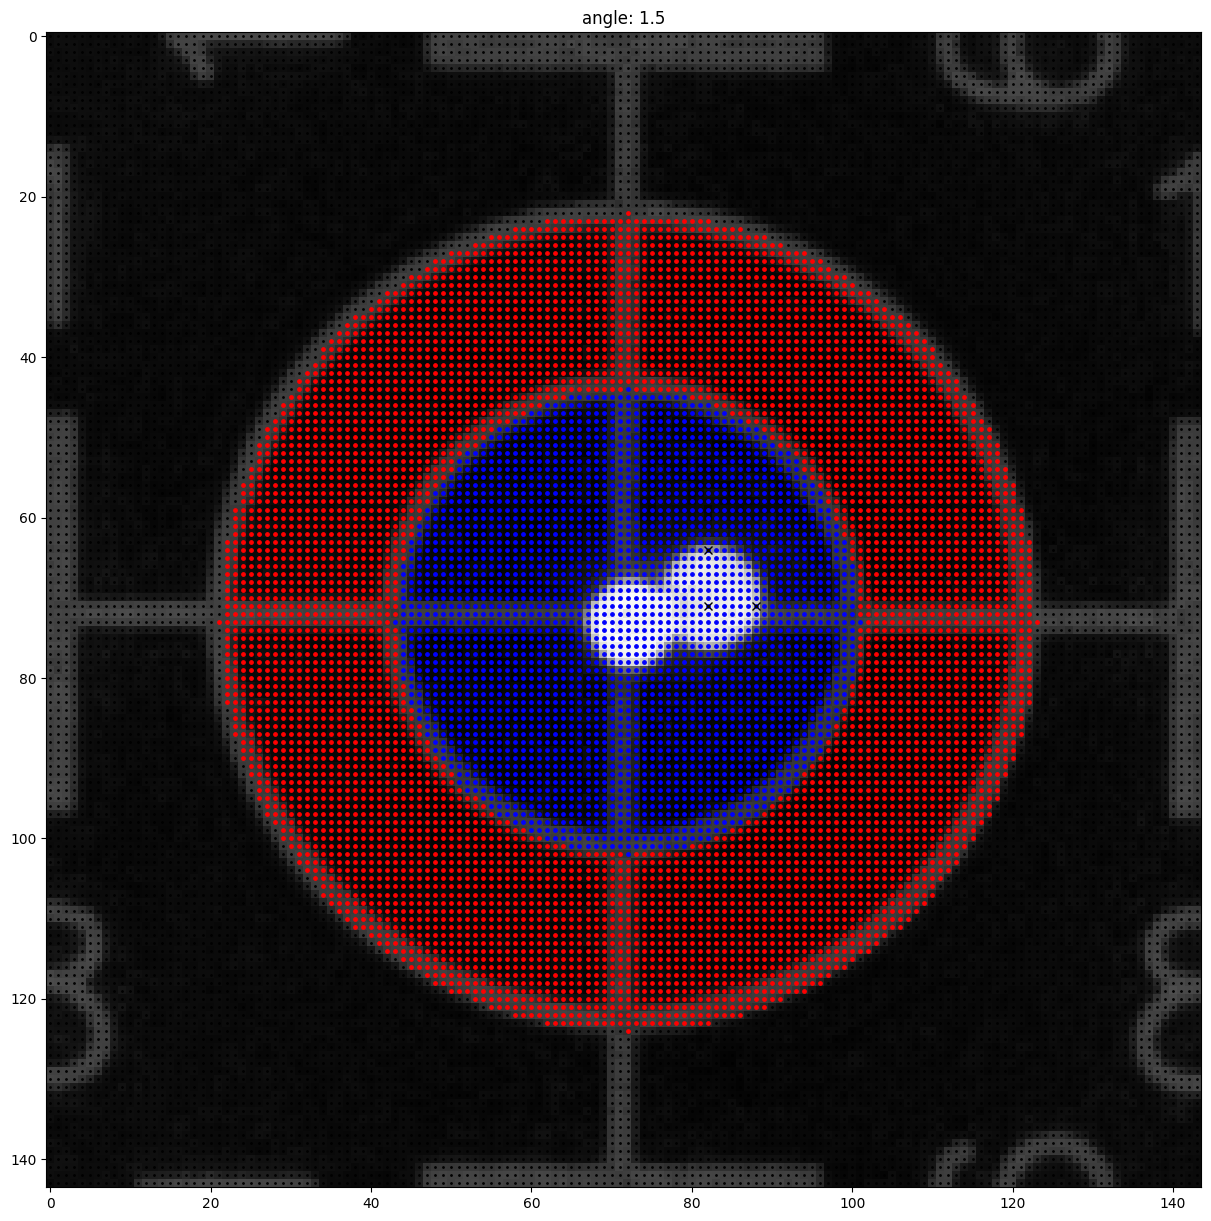

In [93]:
# (x-h)**2 + (y-k)**2 <= r**
inner_points = []
outter_points = []
out = []
h, k = xc, yc
cols = rows = circle_focus.shape[0]
for col in range(cols):
    for row in range(rows):
        x, y = col, row
        if (x-h)**2 + (y-k)**2 <= inner_cir_r**2 :
            inner_points.append([x, y])
        elif (x-h)**2 + (y-k)**2 <= outter_cir_r**2:
            outter_points.append([x, y])
        else:
            out.append([x, y])

inner_points = np.array(inner_points)
outter_points = np.array(outter_points)
out = np.array(out)

plt.figure(figsize=(15, 15))
display(circle_focus, True)
plt.scatter(outter_points[:, 0], outter_points[:, 1], s=6, c='red')
plt.scatter(inner_points[:, 0], inner_points[:, 1], s=6, c='blue')
plt.scatter(out[:, 0], out[:, 1], s=1, c='black')
plt.plot(dev_x, dev_y, "x", c="black")
plt.plot(x1, y1, "x", c="black")
plt.plot(x2, y2, "x", c="black")

point_angle = check_angle(h, k, dev_x, dev_y, inner_cir_r, outter_cir_r)
plt.title(f"angle: {point_angle}")